In [1]:
from datetime import timedelta
from fuzzywuzzy import fuzz

import matplotlib.pyplot as plt
import pandas as pd
import requests
import seaborn as sns

import json
import os

/home/dottyz/miniconda3/envs/open-data/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
r = requests.get('https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information')
bikeshare_stations = json.loads(r.content)['data']['stations']
bikeshare_stations = pd.DataFrame(bikeshare_stations)[['station_id', 'name', 'lat', 'lon']].astype({
    'station_id': 'float64',
})

bikeshare_stations.to_csv('./data/bikeshare_stations.csv', index=False)

In [3]:
bikeshare_stations.sample(10)

,station_id,name,lat,lon
24,7026.0,Bay St / St. Joseph St,43.665527,-79.387499
259,7281.0,Charles St W / Balmuto St - SMART,43.668427,-79.387250
220,7241.0,519 Church St - SMART,43.666805,-79.381288
234,7255.0,Stewart St / Bathurst St - SMART,43.643307,-79.402176
344,7378.0,Yonge St / Davisville Ave,43.697597,-79.396540
128,7134.0,Marlborough Ave / Yonge St,43.680000,-79.391111
103,7108.0,Front St E / Cherry St,43.652686,-79.358395
166,7176.0,Bathurst St / Fort York Blvd,43.639179,-79.399595
105,7110.0,Queen St E / Berkeley St,43.655278,-79.365833
6,7007.0,College St / Huron St,43.658148,-79.398167


In [4]:
# Identify the date structure used by each of the files as a dict:
#      * Key: data file name
#      * Value: [datetime format, hour difference bewteen timezone used and Eastern timezone]

date_formats = {
    'Bikeshare Ridership (2017 Q1).csv': ['%d/%m/%Y %H:%M', -4],
    'Bikeshare Ridership (2017 Q2).csv': ['%d/%m/%Y %H:%M', -4],
    'Bikeshare Ridership (2017 Q3).csv': ['%m/%d/%Y %H:%M', 0],
    'Bikeshare Ridership (2017 Q4).csv': ['%m/%d/%y %H:%M:%S', 0],
}

df = pd.DataFrame() # Initiate an empty DataFrame
for fn, fmt in date_formats.items():
    tmp = pd.read_csv(os.path.join('./data', fn))
    tmp['trip_start_time'] = pd.to_datetime(tmp['trip_start_time'], format=fmt[0], errors='coerce') # Read the datetime in the specified format
    tmp['trip_start_time'] = tmp['trip_start_time'] + timedelta(hours=fmt[1])                       # Convert the input time to the Easter timezone

    df = pd.concat([df, tmp], sort=False).reset_index(drop=True)                                    # Merge the content of the file to the main DataFrame

In [5]:
df.sample(10)

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_id,from_station_name,to_station_id,to_station_name,user_type
19883,736158,2017-01-18 18:08:00,18/01/2017 22:16,511,7123.0,424 Wellington St. W,7033.0,Union Station,Member
512114,1304630,2017-07-07 21:00:00,7/7/2017 21:05,317,NaN,Wellesley St / Queen's Park Cres,NaN,Wellesley St E / Yonge St (Green P),Member
1370530,2240037,2017-11-14 21:54:00,11/14/17 21:57:42,222,NaN,Navy Wharf Ct. / Bremner Blvd.,NaN,King St W / Spadina Ave,Member
799865,1617781,2017-08-18 17:19:00,8/18/2017 17:37,1080,NaN,Trinity St /Front St E,NaN,Carlton St / Parliament St,Member
1084848,1923816,2017-09-24 22:22:00,9/24/2017 22:25,150,NaN,Bay St / Albert St,NaN,King St W / Bay St (West Side),Member
1245388,2099377,2017-10-19 18:45:54,10/19/17 19:06:15,1221,NaN,King St W / Bay St (West Side),NaN,Charles St E / Jarvis St - SMART,Member
175274,918052,2017-04-18 13:08:00,18/04/2017 17:15,456,7170.0,Spadina Ave / Willcocks St,7039.0,Simcoe St / Dundas St W,Member
360734,1133322,2017-06-10 13:58:00,10/6/2017 18:16,1078,7199.0,College St W / Markham St,7073.0,Bremner Blvd / Spadina Ave,Casual
564659,1361777,2017-07-15 19:05:00,7/15/2017 19:10,332,NaN,Jarvis St / Carlton St,NaN,Sherbourne St / Wellesley St E,Member
296246,1058608,2017-05-27 17:06:00,27/05/2017 21:17,691,7162.0,Hayter St / Laplante Ave,7115.0,Howard St / Sherbourne St,Member


In [6]:
stations_start = df[['from_station_id', 'from_station_name']]
stations_end = df[['to_station_id', 'to_station_name']]
stations_start.columns = stations_end.columns = ['station_id', 'name']

# Extracts the unique station ID and name combination from the from_station and to_station columns
stations = pd.concat([stations_start, stations_end]).dropna(how='all').drop_duplicates().reset_index(drop=True)

In [7]:
stations.sample(10)

,station_id,name
40,7039.0,Simcoe St / Dundas St W
241,NaN,25 York St (ACC/Union Station South)
260,NaN,Queen St W / Portland St
93,7121.0,Jarvis St / Dundas St E
106,7173.0,Cariboo St / Rail Path
468,NaN,Bloor St W / Shaw Ave - SMART
57,7019.0,Temperance St / Yonge St
159,7062.0,University Ave / College St
342,NaN,Niagara St / Richmond St W
116,7089.0,Church St / Wood St


In [8]:
# Separate the stations without station IDs
no_ids = stations[stations['station_id'].isnull()]
for idx, miss in no_ids.iterrows():
    max_score = 0
    
    # Compare the similarity of the station without ID to each station in the API data
    for i, exist in bikeshare_stations[['station_id', 'name']].iterrows():
        score = fuzz.ratio(miss['name'], exist['name'])
        
        if score > 80 and score > max_score:
            max_score = score
            no_ids.at[idx, 'station_id'] = exist['station_id']
    
    # Warn if the station was not able to be matched
    if max_score <= 80:
        print('WARN: {0} station could not be matched to an existing station'.format(miss['name']))

# Remove all stations that were not matched
no_ids = no_ids.dropna()

WARN: Michael Sweet Ave / St. Patrick St station could not be matched to an existing station
WARN: Bremner Blvd / Spadina Ave station could not be matched to an existing station
WARN: Bay St / Bloor St W station could not be matched to an existing station
WARN: Bathurst St / Queens Quay W station could not be matched to an existing station
WARN: Wellesley St / Queen's Park Cres station could not be matched to an existing station
WARN: Davenport Rd / Bedford Rd station could not be matched to an existing station
WARN: Victoria St / Gould St (Ryerson University) station could not be matched to an existing station
WARN: Woodbine Subway Green P (Cedarvale Ave) station could not be matched to an existing station
WARN: Stephenson Ave / Main St station could not be matched to an existing station
WARN: Roxton Rd / College St station could not be matched to an existing station
WARN: Base Station station could not be matched to an existing station
WARN: Lake Shore Blvd W / Ontario Dr(Ontario Pla

In [9]:
stations = pd.concat([stations[~stations['station_id'].isnull()], no_ids])\
             .merge(bikeshare_stations[['station_id', 'lat', 'lon']], how='inner', on='station_id')\
             .drop_duplicates()

In [10]:
df = df.merge(stations, how='inner', left_on='from_station_name', right_on='name') \
       .merge(stations, how='inner', left_on='to_station_name', right_on='name', suffixes=['_from', '_to']) \
       .drop_duplicates()

df = df[[x for x in df.columns if not x.endswith('_station_id') and not x.endswith('_station_name') and x != 'trip_stop_time']]

In [11]:
df.sample(10)

,trip_id,trip_start_time,trip_duration_seconds,user_type,station_id_from,name_from,lat_from,lon_from,station_id_to,name_to,lat_to,lon_to
977916,1671674,2017-08-25 08:38:00,1255,Member,7065.0,Dundas St E / Parliament St,43.659575,-79.365769,7046.0,Niagara St / Richmond St W,43.645340,-79.409597
218778,984238,2017-05-10 07:40:00,713,Casual,7054.0,Navy Wharf Ct. / Bremner Blvd.,43.640722,-79.391051,7045.0,Bond St / Queen St E,43.653236,-79.376716
213566,2352105,2017-12-11 16:51:13,975,Member,7139.0,Glen Edyth Dr / Davenport Rd,43.677778,-79.405556,7077.0,College Park South,43.659777,-79.382767
965946,1360265,2017-07-15 16:48:00,1293,Member,7110.0,Queen St E / Berkely St,43.655278,-79.365833,7072.0,Queen St W / Shaw St,43.644524,-79.416519
867468,1268667,2017-07-03 14:58:00,663,Member,7098.0,Riverdale Park South (Broadview Ave),43.667819,-79.353470,7103.0,Jimmie Simpson Park (Queen St E),43.660560,-79.343766
27557,1663911,2017-08-24 09:31:00,444,Member,7102.0,Nelson St / Duncan St,43.648711,-79.389728,7021.0,Bay St / Albert St,43.653264,-79.382458
846933,1620731,2017-08-19 00:51:00,376,Member,7282.0,Adelaide St W / Bay St - SMART,43.650152,-79.379856,7168.0,Queens Quay / Yonge St,43.641646,-79.375308
401064,1544134,2017-08-09 15:08:00,1084,Casual,7033.0,Union Station,43.645609,-79.380386,7000.0,Fort York Blvd / Capreol Crt,43.639832,-79.395954
1109935,1508891,2017-08-04 01:38:00,1366,Casual,7122.0,Niagara St / Tecumseth St,43.641389,-79.404444,7122.0,Niagara St / Tecumseth St,43.641389,-79.404444
593486,2261114,2017-11-20 09:26:52,95,Member,7065.0,Dundas St E / Parliament St,43.659575,-79.365769,7100.0,Dundas St E / Regent Park Blvd,43.660207,-79.361275


In [12]:
df.describe()

,trip_id,trip_duration_seconds,station_id_from,lat_from,lon_from,station_id_to,lat_to,lon_to
count,1.443979e+06,1.443979e+06,1.443979e+06,1.443979e+06,1.443979e+06,1.443979e+06,1.443979e+06,1.443979e+06
mean,1.547715e+06,1.020235e+03,7.094254e+03,4.365383e+01,-7.939058e+01,7.093350e+03,4.365303e+01,-7.939000e+01
std,4.773673e+05,9.924367e+03,7.606454e+01,1.059573e-02,2.010674e-02,7.580636e+01,1.024664e-02,2.023239e-02
min,7.123820e+05,1.000000e+00,7.000000e+03,4.362671e+01,-7.947657e+01,7.000000e+03,4.362671e+01,-7.947657e+01
25%,1.138084e+06,4.140000e+02,7.032000e+03,4.364561e+01,-7.940146e+01,7.033000e+03,4.364561e+01,-7.939960e+01
50%,1.547850e+06,6.540000e+02,7.068000e+03,4.365282e+01,-7.938758e+01,7.067000e+03,4.365228e+01,-7.938750e+01
75%,1.957892e+06,1.019000e+03,7.158000e+03,4.366197e+01,-7.937988e+01,7.157000e+03,4.366030e+01,-7.937986e+01
max,2.383646e+06,6.382030e+06,7.289000e+03,4.369402e+01,-7.928898e+01,7.289000e+03,4.369402e+01,-7.928898e+01


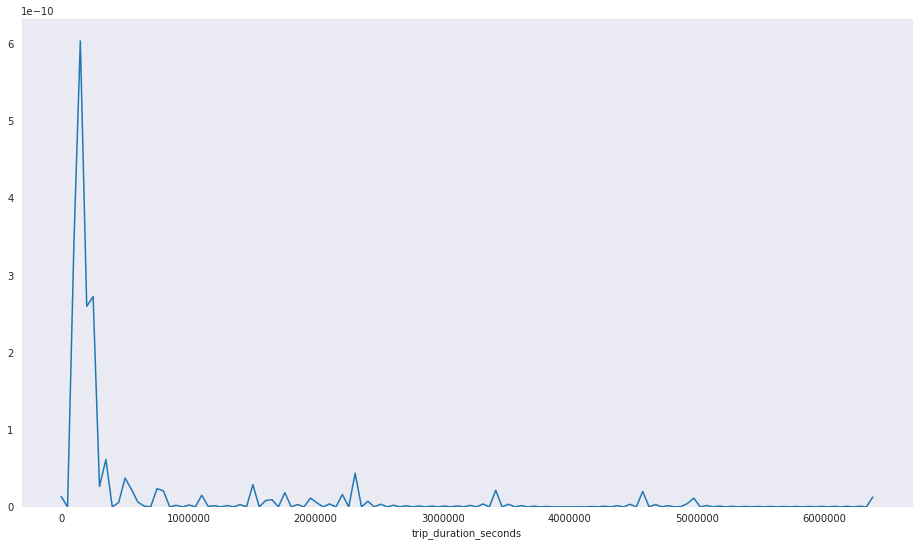

In [13]:
sns.set_style('dark')

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
sns.distplot(df['trip_duration_seconds'], hist=False, ax=ax)

plt.savefig('./visualization/raw_distributions.png')

In [12]:
df.shape

(1443979, 12)

In [13]:
df = df[(df['trip_duration_seconds']>=60)]

In [14]:
df.describe()

,trip_id,trip_duration_seconds,station_id_from,lat_from,lon_from,station_id_to,lat_to,lon_to
count,1.414475e+06,1.414475e+06,1.414475e+06,1.414475e+06,1.414475e+06,1.414475e+06,1.414475e+06,1.414475e+06
mean,1.544063e+06,1.040980e+03,7.094174e+03,4.365387e+01,-7.939057e+01,7.093264e+03,4.365306e+01,-7.938997e+01
std,4.795400e+05,1.002629e+04,7.596690e+01,1.057742e-02,2.004762e-02,7.571064e+01,1.022364e-02,2.017457e-02
min,7.123820e+05,6.000000e+01,7.000000e+03,4.362671e+01,-7.947657e+01,7.000000e+03,4.362671e+01,-7.947657e+01
25%,1.129728e+06,4.280000e+02,7.032000e+03,4.364561e+01,-7.940146e+01,7.033000e+03,4.364561e+01,-7.939960e+01
50%,1.542682e+06,6.650000e+02,7.068000e+03,4.365324e+01,-7.938758e+01,7.067000e+03,4.365228e+01,-7.938750e+01
75%,1.957804e+06,1.029000e+03,7.158000e+03,4.366197e+01,-7.937988e+01,7.157000e+03,4.366041e+01,-7.937986e+01
max,2.383646e+06,6.382030e+06,7.289000e+03,4.369402e+01,-7.928898e+01,7.289000e+03,4.369402e+01,-7.928898e+01


In [15]:
df.shape

(1414475, 12)

In [16]:
q1 = df['trip_duration_seconds'].quantile(0.25)
q3 = df['trip_duration_seconds'].quantile(0.75)
interquartile_range = q3 - q1

df = df[~((df['trip_duration_seconds'] < (q1 - 1.5 * interquartile_range))|(df['trip_duration_seconds'] > (q3 + 1.5 * interquartile_range)))].reset_index(drop=True)

In [17]:
df.shape

(1332419, 12)

In [15]:
df.to_csv('./data/bikeshare_ridership.csv', index=False)